# K modes

## Using K modes algorithm to find clusters 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from scipy.stats import iqr
import time
%matplotlib inline

In [ ]:
#import data

#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

scaler = StandardScaler()

df["age_sd"] = scaler.fit_transform(df[["AGE_YEARS"]])

#6931 DBD apps
dbd_apps = df[(df["eli_DBD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#6060 DBD apps to match cohort in pape
dbd_apps = dbd_apps[(dbd_apps["eth_grp"]!=5)&(dbd_apps["FORMAL_APR_WHEN"]!=4)&(dbd_apps["donation_mentioned"]!=-1)
                    &(dbd_apps["FAMILY_WITNESS_BSDT"]!=9)&(dbd_apps["GENDER"]!=9)]
     
#9965 DCD apps
dcd_apps = df[(df["eli_DCD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#9405 DCD apps to match cohort in paper
dcd_apps = dcd_apps[(dcd_apps["GENDER"]!=9)&(dcd_apps["cod_neuro"].notna())&(dcd_apps["eth_grp"]!=5)&(dcd_apps["donation_mentioned"]!=-1)&
                    (~dcd_apps["DTC_WD_TRTMENT_PRESENT"].isin([8,9]))]

# Consented donors only
dbd_cons = dbd_apps[dbd_apps["FAMILY_CONSENT"]==2]
dcd_cons = dcd_apps[dcd_apps["FAMILY_CONSENT"]==2]

In [ ]:
# Columns used to create DBD model in paper
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "age_sd", "FAMILY_CONSENT"]

dbd_cats = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "FAMILY_CONSENT"]

dbd_apps[dbd_cats].astype(int)

dbd_model_data = dbd_apps.loc[:,dbd_cols]
dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cats[:-1],drop_first=True)

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "age_sd","cod_neuro","FAMILY_CONSENT"]

dcd_cats = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "cod_neuro","FAMILY_CONSENT"]

dcd_apps[dcd_cats].astype(int)

dcd_model_data = dcd_apps.loc[:,dcd_cols]
dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cats[:-1],drop_first=True)

In [ ]:
dcd_model_data

In [ ]:
max_clusters = 10
n_clusters = range(2,max_clusters+1)
costs = []

for k in range(2,max_clusters+1):
    KP = KPrototypes(n_clusters=k)
    KP.fit_predict(dcd_model_data,categorical=list(range(0,8))+[9,10])
    costs.append(KP.cost_)

Text(0, 0.5, 'Cost')

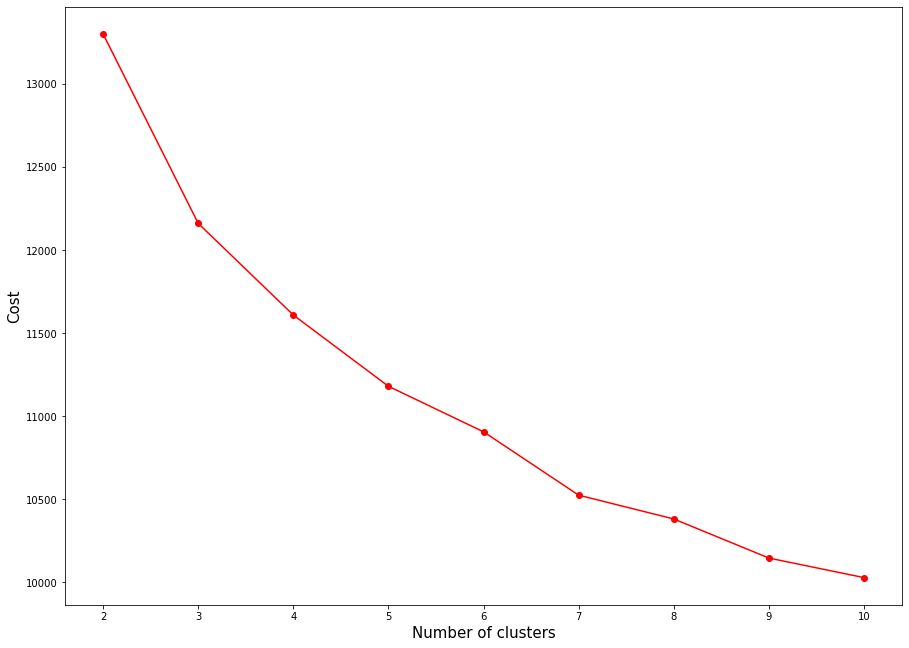

In [36]:
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.plot(n_clusters,costs,"ro-")
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Cost", fontsize=15)

In [75]:
for k in [3,4,5]:
    KP = KPrototypes(n_clusters=k,random_state=66)
    KP.fit_predict(dbd_model_data,categorical=list(range(0,10))+[11])
    dbd_model_data["cluster_k"+str(k)] = KP.labels_

In [76]:
dbd_model_data["age"]= scaler.inverse_transform(dbd_model_data["age_sd"])

dbd_model_data.head()

,wish,FORMAL_APR_WHEN,donation_mentioned,app_nature,eth_grp,religion_grp,GENDER,FAMILY_WITNESS_BSDT,DTC_PRESENT_BSD_CONV,acorn_new,age_sd,FAMILY_CONSENT,cluster_k3,cluster_k4,cluster_k5,age
10,3.0,3.0,1.0,2.0,1.0,4.0,1.0,1.0,2.0,4.0,0.635769,2.0,0,0,2,71.0
11,1.0,3.0,1.0,2.0,1.0,4.0,2.0,1.0,2.0,4.0,0.744975,2.0,0,0,2,73.0
16,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0,0.526564,2.0,0,0,0,69.0
26,4.0,1.0,4.0,2.0,1.0,9.0,2.0,1.0,2.0,4.0,0.035141,2.0,2,2,4,60.0
30,4.0,3.0,4.0,2.0,1.0,9.0,1.0,1.0,2.0,4.0,0.417359,1.0,0,0,2,67.0


In [236]:
k3_summary = dbd_model_data.iloc[:,[-4,-1]].groupby("cluster_k3").agg(["median",iqr]).T
k4_summary = dbd_model_data.iloc[:,[-3,-1]].groupby("cluster_k4").agg(["median",iqr]).T
k5_summary = dbd_model_data.iloc[:,[-2,-1]].groupby("cluster_k5").agg(["median",iqr]).T

all_sum = pd.concat([k3_summary, k4_summary, k5_summary])

In [237]:
all_sum

0     1     2     3     4
age median  65.0  28.0  50.0   NaN   NaN
    iqr     12.0  15.0  10.0   NaN   NaN
    median  68.0  26.0  52.0  49.0   NaN
    iqr     11.0  13.0  11.0  10.0   NaN
    median  55.0  26.0  69.0  48.0  48.0
    iqr     11.0  13.0   9.0  12.0  10.0

In [238]:
def cat_summary(k,col):
    
    summary = dbd_model_data.value_counts(["cluster_k"+str(k),col],sort=False).reset_index(name="count")
    summary["Pct"] = round(100*summary.iloc[:,-1] / summary.groupby("cluster_k"+str(k))["count"].transform('sum'),1)
    
    baseline = dbd_model_data.value_counts(col,sort=False).reset_index(name="count")
    baseline["Baseline Pct"] = round(100*baseline["count"] / baseline["count"].sum(),1)
    
    summary2 = pd.merge(summary,baseline[[col,"Baseline Pct"]],on=col,how="left")
    
    return summary2 

In [239]:
cat_summary(4,"FAMILY_CONSENT")

,cluster_k4,FAMILY_CONSENT,count,Pct,Baseline Pct
0,0,1.0,347,20.4,29.7
1,0,2.0,1351,79.6,70.3
2,1,1.0,327,24.1,29.7
3,1,2.0,1030,75.9,70.3
4,2,1.0,376,20.2,29.7
5,2,2.0,1485,79.8,70.3
6,3,1.0,750,65.6,29.7
7,3,2.0,394,34.4,70.3


In [218]:
cat_summary(4,"acorn_new")

,cluster_k4,acorn_new,count,Pct,Baseline Pct
0,0,1.0,381,22.4,15.5
1,0,2.0,96,5.7,6.1
2,0,3.0,556,32.7,20.6
3,0,4.0,202,11.9,20.4
4,0,5.0,211,12.4,19.5
5,0,6.0,252,14.8,17.7
6,1,1.0,139,10.2,15.5
7,1,2.0,100,7.4,6.1
8,1,3.0,244,18.0,20.6
9,1,4.0,265,19.5,20.4


In [240]:
cat_summary(4,"eth_grp")

,cluster_k4,eth_grp,count,Pct,Baseline Pct
0,0,1.0,1546,91.0,85.3
1,0,2.0,74,4.4,6.7
2,0,3.0,49,2.9,4.8
3,0,4.0,29,1.7,3.2
4,1,1.0,1136,83.7,85.3
5,1,2.0,97,7.1,6.7
6,1,3.0,63,4.6,4.8
7,1,4.0,61,4.5,3.2
8,2,1.0,1685,90.5,85.3
9,2,2.0,86,4.6,6.7


In [241]:
cat_summary(4,"donation_mentioned")

,cluster_k4,donation_mentioned,count,Pct,Baseline Pct
0,0,1.0,1058,62.3,61.3
1,0,2.0,402,23.7,22.3
2,0,3.0,12,0.7,0.6
3,0,4.0,226,13.3,15.8
4,1,1.0,724,53.4,61.3
5,1,2.0,323,23.8,22.3
6,1,3.0,10,0.7,0.6
7,1,4.0,300,22.1,15.8
8,2,1.0,1153,62.0,61.3
9,2,2.0,412,22.1,22.3


In [242]:
cat_summary(4,"religion_grp")

,cluster_k4,religion_grp,count,Pct,Baseline Pct
0,0,1.0,804,47.3,37.9
1,0,2.0,29,1.7,3.9
2,0,3.0,28,1.6,1.6
3,0,4.0,330,19.4,18.5
4,0,5.0,42,2.5,3.1
5,0,9.0,465,27.4,35.0
6,1,1.0,581,42.8,37.9
7,1,2.0,74,5.5,3.9
8,1,3.0,26,1.9,1.6
9,1,4.0,225,16.6,18.5


In [243]:
cat_summary(4,"wish")

,cluster_k4,wish,count,Pct,Baseline Pct
0,0,1.0,944,55.6,56.5
1,0,2.0,91,5.4,4.8
2,0,3.0,273,16.1,15.3
3,0,4.0,328,19.3,18.1
4,0,5.0,62,3.7,5.3
5,1,1.0,780,57.5,56.5
6,1,2.0,68,5.0,4.8
7,1,3.0,167,12.3,15.3
8,1,4.0,237,17.5,18.1
9,1,5.0,105,7.7,5.3


In [244]:
cat_summary(4,"GENDER")

,cluster_k4,GENDER,count,Pct,Baseline Pct
0,0,1.0,1016,59.8,52.1
1,0,2.0,682,40.2,47.9
2,1,1.0,868,64.0,52.1
3,1,2.0,489,36.0,47.9
4,2,1.0,482,25.9,52.1
5,2,2.0,1379,74.1,47.9
6,3,1.0,791,69.1,52.1
7,3,2.0,353,30.9,47.9
